# Wczytanie Bibliotek

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_directory = '/content/drive/MyDrive/Colab Notebooks/'
file_name = 'custom_features_30_s.csv'

# Extracting features

extract_features(file_path) is used to load a .wav file and extract a number of features using the librosa library. These will later be saved in a .csv file.

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    
    # Extract features using librosa
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    harmonic, percussive = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # Calculate mean and variance values of features
    features = np.hstack([np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
                      np.mean(chroma), np.var(chroma),
                      np.mean(spec_contrast), np.var(spec_contrast),
                      np.mean(tonnetz), np.var(tonnetz),
                      np.mean(spec_centroid), np.var(spec_centroid),
                      np.mean(spec_bandwidth), np.var(spec_bandwidth),
                      np.mean(spec_rolloff), np.var(spec_rolloff),
                      np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                      np.mean(rms), np.var(rms),
                      np.mean(harmonic), np.var(harmonic),
                      np.mean(percussive), np.var(percussive),
                      tempo])

    return features

process_directory(input_dir, genre) iterates over all files in input directory. It then extracts features and appends them to data array.

In [ ]:
def process_directory(input_dir, genre):
    data = []
    for file in os.listdir(input_dir):
        try:
          if file.endswith('.wav'):
              file_path = os.path.join(input_dir, file)
              features = extract_features(file_path)
              data.append([file, genre] + list(features))
        except:
            print('An error occured for file: ' + file.__str__())
    return data

In [ ]:
input_directories = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
genres = input_directories
input_directories = [os.path.join(base_directory, 'Data', 'genres_original', genre) for genre in genres]

We iterate over all files in all genres and add them to all_data array.

In [ ]:
all_data = []
for directory, genre in zip(input_directories, genres):
    data = process_directory(directory, genre)
    all_data.extend(data)

An error occured for file: blues.00012.wav
An error occured for file: blues.00015.wav
An error occured for file: blues.00005.wav
An error occured for file: blues.00013.wav
An error occured for file: blues.00010.wav


We add filename and label columns to our array and then change it to DataFrame to then save it to a csv file using to_csv(). The process of extracting data is very time consuming so saving this data to a file lets us traing the moddel without wasting time on extracting features every time.

In [ ]:
columns = ['filename', 'label'] + [f'feature_{i}' for i in range(len(all_data[0]) - 2)]
df = pd.DataFrame(all_data, columns=columns)

In [ ]:
df.to_csv(os.path.join(base_directory, 'Data', file_name), index=False)

# Training the model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

We load the data into a data frame

In [ ]:
file = base_directory + 'Data/' + file_name
df = pd.read_csv(file)

We extract labels from 'label' column and then remove 'label' and 'filename' columns to not train on data with a label in it.

In [ ]:
y = df['label']
unique_genres = y.unique()
le = LabelEncoder()
y = le.fit_transform(y)

X = df.drop('label', axis=1).drop('filename', axis=1)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

We choose the params of our model. 
'tree_method': 'gpu_hist', can be uncommented if we want our model to run on GPU.

In [ ]:
params = {
    'learning_rate': 0.3,
    'n_estimators': 250,
    'max_depth': 4,
    # 'tree_method': 'gpu_hist',
    'gamma': 0,
    'colsample_bytree': 1,
    'subsample': 1,
     'min_child_weight': 3,
     'reg_alpha': 0,
    'reg_lambda': 1.5,
    'max_delta_step': 1
}

We train our model and check its accuracy.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
model = XGBClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


We graph preddictions our model made.

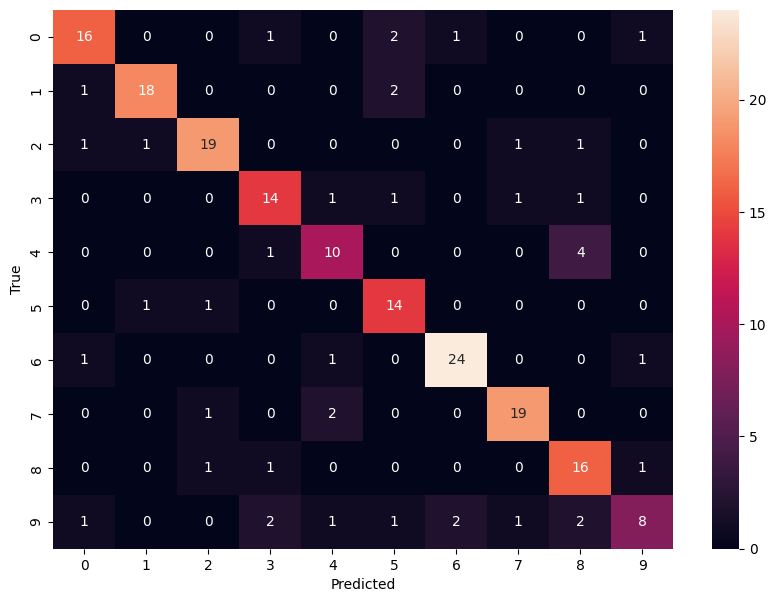

In [ ]:
genres = model.classes_
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=unique_genres))

              precision    recall  f1-score   support

       blues       0.80      0.76      0.78        21
   classical       0.90      0.86      0.88        21
     country       0.86      0.83      0.84        23
       disco       0.74      0.78      0.76        18
      hiphop       0.67      0.67      0.67        15
        jazz       0.70      0.88      0.78        16
       metal       0.89      0.89      0.89        27
         pop       0.86      0.86      0.86        22
      reggae       0.67      0.84      0.74        19
        rock       0.73      0.44      0.55        18

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.79      0.79      0.79       200



Here we can add parameter names to 'param_grid'. Then fit() function will then test all possible combinations of these parameters and test which ones give the best results. Then we ourput which parameters are the best and what accuracy they achieve. This cell was used to obtain the parameters our model uses.

In [ ]:
param_grid = {
    
}
gbm = XGBClassifier(**params) # GradientBoostingClassifier
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters:", best_params)
print("Best accuracy score:", best_score)

best_model = XGBClassifier({**best_params, **params}, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)